In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# --- CONFIGURACIÓN Y CARGA DEL ARCHIVO REAL ---

IMAGEN_FILE = 'Imagen_con_detalles_escondidos.tif'

try:
    # Cargar la imagen en escala de grises (necesario para la ecualización)
    img_original = cv2.imread(IMAGEN_FILE, cv2.IMREAD_GRAYSCALE)
    if img_original is None:
        raise FileNotFoundError(f"El archivo '{IMAGEN_FILE}' no se pudo cargar. Verifique el nombre y que sea un archivo de imagen válido.")
    print(f"Imagen '{IMAGEN_FILE}' cargada exitosamente.")

except Exception as e:
    print(f"ERROR al cargar la imagen: {e}")
    # Terminamos la ejecución si no se puede cargar la imagen real
    exit()

Imagen 'Imagen_con_detalles_escondidos.tif' cargada exitosamente.


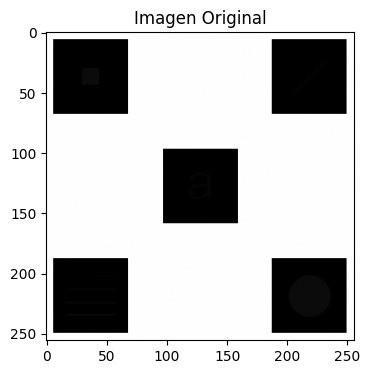

In [9]:
# Veamos la imagen original...
plt.figure(figsize=(10, 4))
plt.title('Imagen Original')
plt.imshow(img_original, cmap='gray')   
plt.show()


In [ ]:
# Verificamos las caracteristicas de la imagen cargada
print('Dimensiones:', img_original.ndim,'\nTamaño:', img_original.shape)

Dimensiones: 2 
Tamaño: (256, 256)


In [ ]:
# --- FUNCIÓN DE ECUALIZACIÓN LOCAL DEL HISTOGRAMA (LHE) ---

def ecualizacion_local(img, win_h, win_w):
    
    if img.ndim > 2:
        raise ValueError("La ecualización local debe aplicarse a imágenes en escala de grises.")

    if win_h % 2 == 0 or win_w % 2 == 0:
        raise ValueError("El alto y ancho de la ventana deben ser números impares.")

    H, W = img.shape
    # Armado de un array vacío para la imagen resultante
    img_lhe = np.zeros_like(img, dtype=np.uint8) 

    pad_h = win_h // 2
    pad_w = win_w // 2

    # 1. Aplicar padding (BORDER_REPLICATE)
    img_padded = cv2.copyMakeBorder(img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_REPLICATE)

    num_pixels = win_h * win_w # Tamaño de la ventana M x N

    # 2. Recorrer la imagen píxel por píxel
    for y in range(H):
        for x in range(W):
            # 3. Definir la ventana (vecindario)
            y_start, y_end = y, y + win_h
            x_start, x_end = x, x + win_w

            ventana = img_padded[y_start:y_end, x_start:x_end]

            # 4. Calcular el histograma y la FDC de la ventana
            hist, _ = np.histogram(ventana.flatten(), 256, [0, 256])
            cdf = hist.cumsum()

            # 5. Normalizar la FDC (FDC normalizada y escalada a 0-255)
            cdf_min = cdf[cdf > 0].min() # El valor mínimo (no nulo) de la FDC

            # Evitar división por cero
            if num_pixels - cdf_min == 0:
                 scale_factor = 0
            else:
                 scale_factor = 255 / (num_pixels - cdf_min)

            # 6. Aplicar la transformación al píxel central (img[y, x])
            pixel_val = img[y, x]
            new_val = np.round((cdf[pixel_val] - cdf_min) * scale_factor)

            img_lhe[y, x] = np.clip(new_val, 0, 255)

    return img_lhe


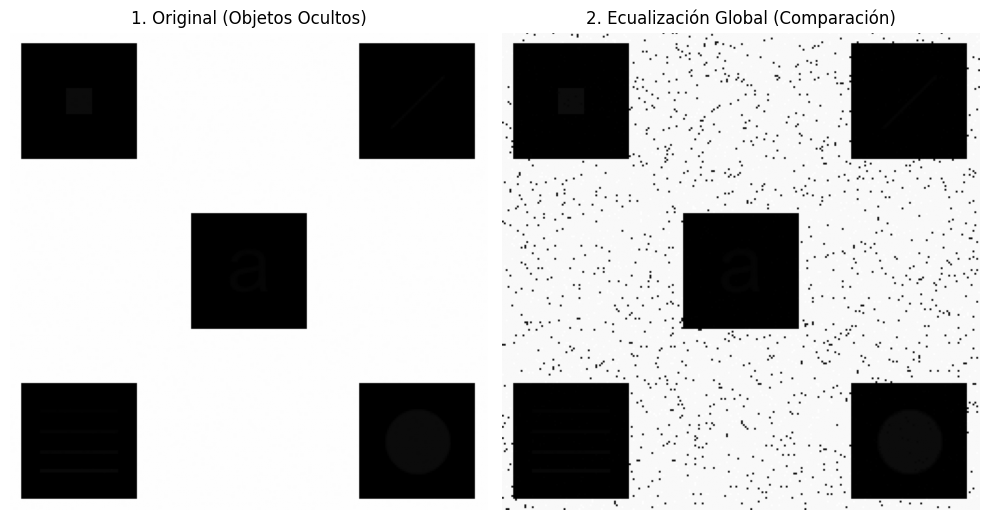

In [ ]:
# --- ANÁLISIS Y COMPARACIÓN DE RESULTADOS ---

# Comenzamos por aplicar Ecualización Global para comparación
img_global = cv2.equalizeHist(img_original)

# Configuración de Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img_original, cmap='gray')
axes[0].set_title("1. Original (Objetos Ocultos)")
axes[0].axis('off')

axes[1].imshow(img_global, cmap='gray')
axes[1].set_title("2. Ecualización Global (Comparación)")
axes[1].axis('off')
plt.tight_layout()


Iniciando Ecualización Local. Esto puede tardar varios minutos...


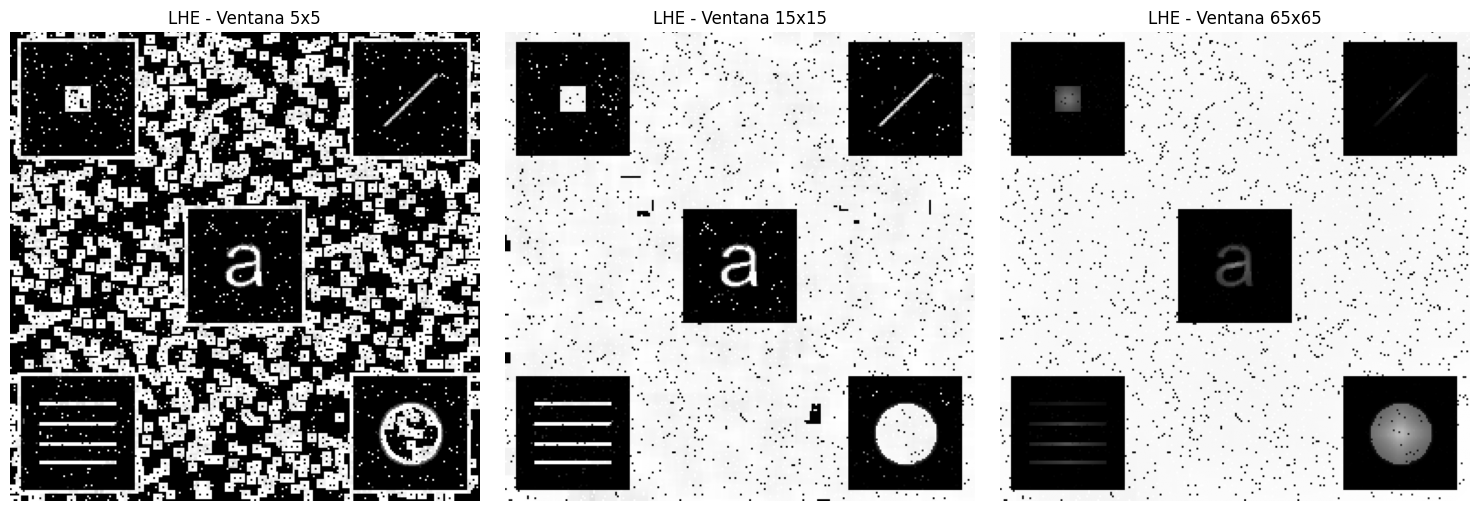

In [18]:
print("\nIniciando Ecualización Local. Esto puede tardar varios minutos...")

# 1. Corregir figsize para un mejor tamaño horizontal (mediano) y una fila de 3 subtramas
fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

# Tamaños de ventana para el análisis (siempre impares) 
# ¿POR QUÉ IMPAR? Porque tiene que haber un píxel central.
ventanas = [(5, 5), (15, 15), (65, 65)]

# Aplicar la función LHE a cada tamaño de ventana
for i, (wh, ww) in enumerate(ventanas):
    # Asegúrate de que el índice no exceda el número de subtramas
    if i < len(axes): 
        try:
            # 1. Aplicar LHE          
            img_lhe = ecualizacion_local(img_original, wh, ww) 

            # 2. Muestra en la figura usando el índice 'i' para cada subtrama
            axes[i].imshow(img_lhe, cmap='gray')
            
            # Establece el título en la subtrama correcta
            axes[i].set_title(f"LHE - Ventana {wh}x{ww}")
            
            # 3. Eliminar ejes para un aspecto más limpio (mediano y alineado)
            axes[i].axis('off') 

        except Exception as e:
            print(f"Error al procesar con ventana {wh}x{ww}: {e}")
    else:
        print("Advertencia: El número de ventanas excede el número de subtramas definidas.")


plt.tight_layout() # Ajusta automáticamente los parámetros de la subtrama para dar espacio
plt.show()

*INFORME DE OBJETOS REVELADOS*

El análisis se realiza contrastando la imagen original con las imágenes ecualizadas localmente:

Detalles Revelados por la Ecualización Local (LHE):

Al aplicar LHE, el contraste se amplifica solo dentro de la pequeña ventana de análisis, revelando los detalles que tenían valores de intensidad muy cercanos al fondo local.

1) Cuadrante Superior Izquierdo: Se revela un cuadrado pequeño centrado.

2) Cuadrante Inferior Izquierdo: Se revelan cuatro líneas horizontales paralelas.

3) Cuadrante Superior Derecho: No se revela ningún objeto (el cuadrante se mantiene uniforme o revela ruido uniforme).

4) Cuadrante Inferior Derecho: Se revela un círculo relleno o contorneado centrado.

5) Centro de la Imagen: Se revela la letra 'a' que estaba oculta en la zona central. 

Análisis de la Ventana: 

Una ventana pequeña (ej. 5x5) genera mucho ruido (granulado) pero máximo detalle.

Una ventana media (ej. 15x15) ofrece el mejor balance, revelando los objetos sin excesivo ruido.

Una ventana grande (ej. 65x65) reduce el ruido, pero si es demasiado grande, el contraste se reduce, acercándose al resultado de la Ecualización Global. Vale aclarar que el enunciado pedía una ventana de 45 x 45 pero elegimos 65 x 65 porque es mas notorio como el aumento de ventana reduce mucho el contraste. 
